In [1]:
import copy
import json
import pickle
import warnings

import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, RandomOverSampler, BorderlineSMOTE
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset

from models.main import get_model, train_model
from models.neural_network import NeuralNetwork
from preprocessing import PreProcessing

C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [2]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [3]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [4]:
game_1_data.iloc[:, 25:-2] = -1 * game_1_data.iloc[:, 25:-2]
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,-0.55243,-0.43269,-0.50067,-0.94322,-0.43693,-0.05002,-0.37833,-0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,-0.55243,-0.43269,-0.50067,-0.94322,-0.43693,-0.05002,-0.37833,-0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,-0.55243,-0.43269,-0.50067,-0.94322,-0.43693,-0.05002,-0.37833,-0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,-0.55236,-0.43313,-0.50034,-0.94391,-0.43644,-0.05038,-0.37756,-0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,-0.55202,-0.43311,-0.50017,-0.94434,-0.43580,-0.04977,-0.37663,-0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,-0.10317,-0.81976,-0.19836,-0.45137,-0.29416,-0.48874,-0.35600,-0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,-0.10319,-0.81960,-0.19831,-0.45182,-0.29373,-0.48836,-0.35583,-0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,-0.10285,-0.81944,-0.19805,-0.45200,-0.29331,-0.48800,-0.35561,-0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,-0.10231,-0.81944,-0.19766,-0.45237,-0.29272,-0.48789,-0.35532,-0.55243,0.03058,0.99726


In [5]:
game_2_data.iloc[:, 25:-2] = -1 * game_2_data.iloc[:, 25:-2]
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,-0.43313,-0.31354,-0.49889,0.02263,-0.50177,-0.50145,-0.49517,-0.36234,0.50216,0.50376
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,-0.43313,-0.31354,-0.49889,0.02263,-0.50177,-0.50145,-0.49517,-0.36234,0.50216,0.50376
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,-0.43313,-0.31354,-0.49889,0.02263,-0.50177,-0.50145,-0.49517,-0.36234,0.50216,0.50376
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,-0.43313,-0.31354,-0.49889,0.02263,-0.50177,-0.50145,-0.49517,-0.36234,0.50216,0.50376
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,-0.43313,-0.31354,-0.49889,0.02263,-0.50177,-0.50145,-0.49517,-0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,-0.46751,-1.05000,-0.44966,-0.41572,-0.26855,-0.61845,-0.36760,-0.12496,0.40958,-0.03891
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,-0.46790,-1.05000,-0.44983,-0.41550,-0.26855,-0.61845,-0.36760,-0.12496,0.40958,-0.03891
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,-0.46818,-1.05000,-0.44997,-0.41485,-0.26855,-0.61845,-0.36760,-0.12496,0.40958,-0.03891
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,-0.46855,-1.05000,-0.45017,-0.41515,-0.26855,-0.61845,-0.36760,-0.12496,0.40958,-0.03891


## Tracking for individual Players for the First Period

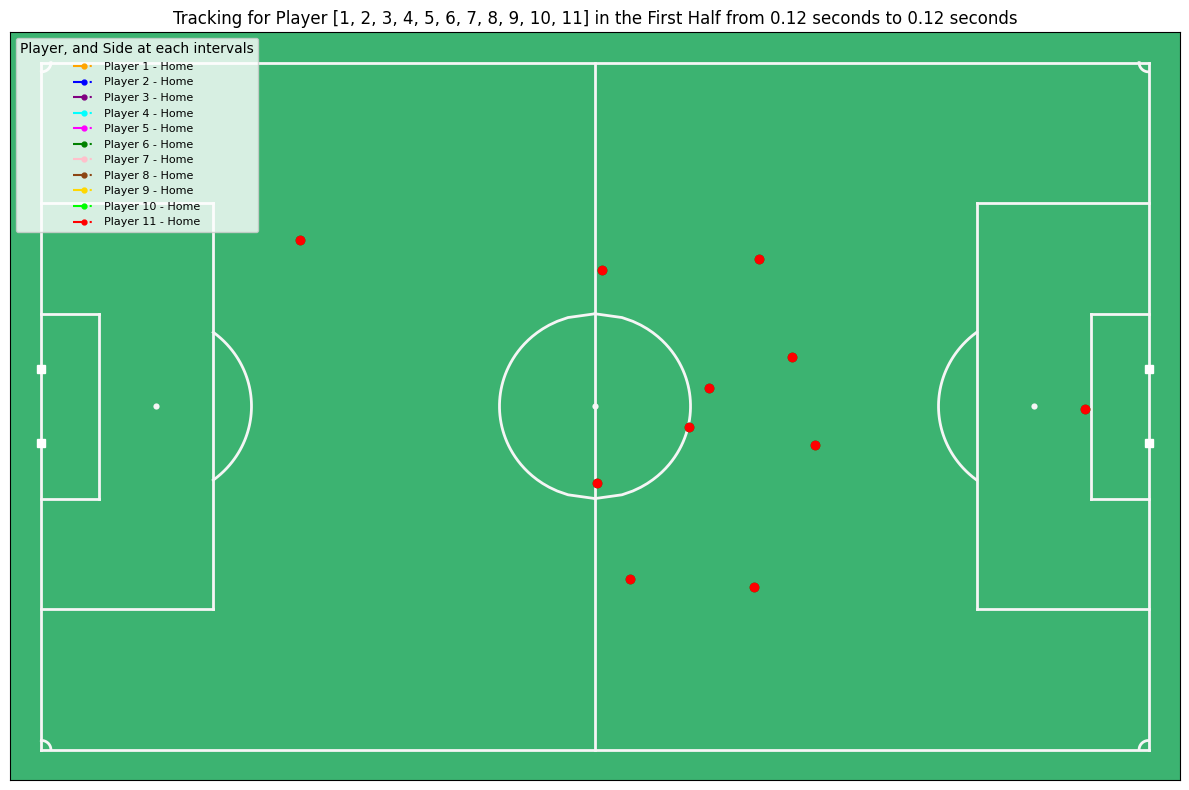

In [6]:
game_2_pre.player_visualization(game_2_data.iloc[2:3], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=False)

In [7]:
# player_tracking(period_1_data)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Adding extra features to dataset

In [25]:
vel_acc_game_1_data = game_1_pre.vel_acc(game_1_data)
vel_acc_game_2_data = game_2_pre.vel_acc(game_2_data)

In [26]:
vel_acc_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.151215,NaN
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.123138,-0.701914
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.011138,0.278458,0.019121,0.478033,0.015201,0.380019,0.029611,0.740275,0.415521,-17.690434
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.008515,-0.065591,0.011560,-0.189042,0.022103,0.172568,0.029100,-0.012774,0.417319,0.044937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.010198,0.098326,0.002704,0.017604,0.013613,0.028951,0.017509,0.062515,0.000000,0.000000
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.004031,-0.154173,0.011319,0.215377,0.014346,0.018330,0.022407,0.122446,0.000000,0.000000
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.009394,0.134075,0.007906,-0.085338,0.013829,-0.012921,0.009100,-0.332665,0.000000,0.000000
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.013500,0.102646,0.013440,0.138350,0.015004,0.029371,0.007754,-0.033653,0.000000,0.000000


In [27]:
vel_acc_game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00875,0.06250,0.010000,-0.027615,0.0,0.0,0.0,0.0,0.0,0.0
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00975,0.02500,0.006951,-0.076232,0.0,0.0,0.0,0.0,0.0,0.0
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00700,-0.06875,0.016623,0.241798,0.0,0.0,0.0,0.0,0.0,0.0
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00925,0.05625,0.009014,-0.190219,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
game_1_ply_tra = vel_acc_game_1_data.iloc[:, 3:]
game_2_ply_tra = vel_acc_game_2_data.iloc[:, 3:]

In [29]:
game_2_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00875,0.06250,0.010000,-0.027615,0.0,0.0,0.0,0.0,0.0,0.0
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00975,0.02500,0.006951,-0.076232,0.0,0.0,0.0,0.0,0.0,0.0
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00700,-0.06875,0.016623,0.241798,0.0,0.0,0.0,0.0,0.0,0.0
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00925,0.05625,0.009014,-0.190219,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# game_1_players, game_1_vel_acc = game_1_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_1_ply_tra.loc[:,"P_1_velocity":]
# game_2_players, game_2_vel_acc = game_2_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_2_ply_tra.loc[:,"P_1_velocity":]

In [31]:
game_1_player_data = game_1_pre.get_frames(game_1_ply_tra, columns=game_1_ply_tra.columns[0:46:2]).round(4).fillna(0)
game_2_player_data = game_2_pre.get_frames(game_2_ply_tra, columns=game_2_ply_tra.columns[0:46:2]).round(4).fillna(0)

In [11]:
game_1_player_data = game_1_data.iloc[:, 3:]
game_1_player_data

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,-0.55243,-0.43269,-0.50067,-0.94322,-0.43693,-0.05002,-0.37833,-0.27383,0.45472,0.38709
2,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,-0.55243,-0.43269,-0.50067,-0.94322,-0.43693,-0.05002,-0.37833,-0.27383,0.49645,0.40656
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,-0.55243,-0.43269,-0.50067,-0.94322,-0.43693,-0.05002,-0.37833,-0.27383,0.53716,0.42556
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,-0.55236,-0.43313,-0.50034,-0.94391,-0.43644,-0.05038,-0.37756,-0.27473,0.55346,0.42231
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,-0.55202,-0.43311,-0.50017,-0.94434,-0.43580,-0.04977,-0.37663,-0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,0.67513,0.11428,0.92765,...,-0.10317,-0.81976,-0.19836,-0.45137,-0.29416,-0.48874,-0.35600,-0.55371,0.03058,0.99726
145003,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,0.67529,0.11428,0.92765,...,-0.10319,-0.81960,-0.19831,-0.45182,-0.29373,-0.48836,-0.35583,-0.55283,0.03058,0.99726
145004,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,0.67501,0.11428,0.92765,...,-0.10285,-0.81944,-0.19805,-0.45200,-0.29331,-0.48800,-0.35561,-0.55254,0.03058,0.99726
145005,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,0.67468,0.11428,0.92765,...,-0.10231,-0.81944,-0.19766,-0.45237,-0.29272,-0.48789,-0.35532,-0.55243,0.03058,0.99726


In [12]:
game_2_player_data = game_2_data.iloc[:, 3:]
game_2_player_data

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,-0.43313,-0.31354,-0.49889,0.02263,-0.50177,-0.50145,-0.49517,-0.36234,0.50216,0.50376
2,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,-0.43313,-0.31354,-0.49889,0.02263,-0.50177,-0.50145,-0.49517,-0.36234,0.50216,0.50376
3,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,-0.43313,-0.31354,-0.49889,0.02263,-0.50177,-0.50145,-0.49517,-0.36234,0.50216,0.50376
4,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,-0.43313,-0.31354,-0.49889,0.02263,-0.50177,-0.50145,-0.49517,-0.36234,0.50216,0.50376
5,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,-0.43313,-0.31354,-0.49889,0.02263,-0.50177,-0.50145,-0.49517,-0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,-0.46751,-1.05000,-0.44966,-0.41572,-0.26855,-0.61845,-0.36760,-0.12496,0.40958,-0.03891
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,-0.46790,-1.05000,-0.44983,-0.41550,-0.26855,-0.61845,-0.36760,-0.12496,0.40958,-0.03891
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,-0.46818,-1.05000,-0.44997,-0.41485,-0.26855,-0.61845,-0.36760,-0.12496,0.40958,-0.03891
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,-0.46855,-1.05000,-0.45017,-0.41515,-0.26855,-0.61845,-0.36760,-0.12496,0.40958,-0.03891


# Classification

In [13]:
def change_player_name(data: pd.Series) -> pd.Series:
    result = []
    name = ""
    for i in range(len(data)):
        item = data.iloc[i]
        if len(item) == 8:
            if int(item[-2:]) < 12:
                name = f"Home-P_{item[-2:]}"
            else:
                name = f"Away-P_{item[-2:]}"
        else:
            name = f"Home-P_{item[-1:]}"
            
        result.append(name)

    return pd.Series(data=result, name=data.name)

In [14]:
game_1_event_data = pd.read_csv("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv")
game_2_event_data = pd.read_csv("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv")

In [15]:
game_1_event_data

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,Home,PASS,NaN,2,143361,5734.44,143483,5739.32,Player12,Player13,0.60,0.33,0.19,0.95
1741,Home,PASS,NaN,2,143578,5743.12,143593,5743.72,Player13,Player4,0.09,0.88,0.14,0.69
1742,Home,BALL LOST,INTERCEPTION,2,143598,5743.92,143618,5744.72,Player4,NaN,0.13,0.69,0.07,0.61
1743,Away,RECOVERY,BLOCKED,2,143617,5744.68,143617,5744.68,Player16,NaN,0.05,0.62,NaN,NaN


In [16]:
game_1_event_data = game_1_event_data[~(game_1_event_data["Type"] == "FAULT RECEIVED")]
game_2_event_data = game_2_event_data[~(game_2_event_data["Type"] == "FAULT RECEIVED")]

game_1_event_data = game_1_event_data.replace("RECOVERY", "BALL LOST")
game_2_event_data = game_2_event_data.replace("RECOVERY", "BALL LOST")

In [17]:
game_2_event_data

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,0.54,0.77,0.29,0.24
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,0.31,0.30,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,0.32,0.30,NaN,NaN
1933,Home,BALL LOST,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,0.34,0.32,NaN,NaN


In [18]:
game_1_event_data = game_1_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]
game_2_event_data = game_2_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]

In [19]:
game_1_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,1,0,Player19,NaN
1,PASS,1,3,Player19,Player21
2,PASS,3,17,Player21,Player15
3,PASS,45,61,Player15,Player19
4,PASS,77,96,Player19,Player21
...,...,...,...,...,...
1740,PASS,143361,143483,Player12,Player13
1741,PASS,143578,143593,Player13,Player4
1742,BALL LOST,143598,143618,Player4,NaN
1743,BALL LOST,143617,143617,Player16,NaN


In [20]:
def fix_events(event_dataset):
    fixed_event_df = event_dataset.copy()
    
    start_frames = fixed_event_df["Start Frame"].values
    end_frames = fixed_event_df["End Frame"].values
    
    conflict_indices = np.where(start_frames[1:] == end_frames[:-1])[0] + 1
    
    fixed_event_df.loc[fixed_event_df.index[conflict_indices], "Start Frame"] += 1
    
    return fixed_event_df

In [21]:
# game_1_event_data = fix_events(game_1_event_data)
# game_2_event_data = fix_events(game_2_event_data)

In [22]:
game_1_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,1,0,Player19,NaN
1,PASS,1,3,Player19,Player21
2,PASS,3,17,Player21,Player15
3,PASS,45,61,Player15,Player19
4,PASS,77,96,Player19,Player21
...,...,...,...,...,...
1740,PASS,143361,143483,Player12,Player13
1741,PASS,143578,143593,Player13,Player4
1742,BALL LOST,143598,143618,Player4,NaN
1743,BALL LOST,143617,143617,Player16,NaN


In [23]:
start_frames = game_1_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = game_1_event_data["End Frame"].iloc[1:].to_numpy()
event_types = game_1_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = game_1_data.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(min(i, j), max(i, j) + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
game_1_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    game_1_event.loc[s:e, "Type"] = e_t

game_1_event = game_1_event.dropna()

In [24]:
game_1_event

,Type
1,PASS
2,PASS
3,PASS
4,PASS
5,PASS
...,...
143626,BALL OUT
143627,BALL OUT
143628,BALL OUT
143629,BALL OUT


In [25]:
start_frames = game_2_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = game_2_event_data["End Frame"].iloc[1:].to_numpy()
event_types = game_2_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = game_2_data.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(min(i, j), max(i, j) + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
game_2_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    game_2_event.loc[s:e, "Type"] = e_t

game_2_event = game_2_event.dropna()

In [26]:
game_2_event

,Type
51,PASS
52,PASS
53,PASS
54,PASS
55,PASS
...,...
140294,BALL OUT
140295,BALL OUT
140296,BALL OUT
140297,BALL OUT


In [27]:
common_indices = game_1_event.index.intersection(game_1_player_data.index)
X_1 = game_1_player_data.loc[common_indices]
y_1 = game_1_event.loc[common_indices, "Type"]

In [28]:
common_indices = game_2_event.index.intersection(game_2_player_data.index)
X_2 = game_2_player_data.loc[common_indices]
y_2 = game_2_event.loc[common_indices, "Type"]

In [29]:
X_1

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,-0.55243,-0.43269,-0.50067,-0.94322,-0.43693,-0.05002,-0.37833,-0.27383,0.45472,0.38709
2,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,-0.55243,-0.43269,-0.50067,-0.94322,-0.43693,-0.05002,-0.37833,-0.27383,0.49645,0.40656
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,-0.55243,-0.43269,-0.50067,-0.94322,-0.43693,-0.05002,-0.37833,-0.27383,0.53716,0.42556
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,-0.55236,-0.43313,-0.50034,-0.94391,-0.43644,-0.05038,-0.37756,-0.27473,0.55346,0.42231
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,-0.55202,-0.43311,-0.50017,-0.94434,-0.43580,-0.04977,-0.37663,-0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143626,0.87421,0.49130,0.24651,0.54960,0.46768,0.45048,0.50410,0.57573,0.10256,0.66565,...,-0.06431,-0.65367,-0.32045,-0.35375,-0.44823,-0.50130,-0.27748,-0.56585,0.03980,0.79348
143627,0.87414,0.49134,0.24621,0.54978,0.46737,0.45075,0.50368,0.57551,0.10215,0.66481,...,-0.06270,-0.65501,-0.31898,-0.35450,-0.44782,-0.50194,-0.27588,-0.56625,0.03749,0.84442
143628,0.87409,0.49134,0.24593,0.54995,0.46703,0.45103,0.50329,0.57527,0.10175,0.66396,...,-0.06111,-0.65633,-0.31752,-0.35531,-0.44741,-0.50256,-0.27428,-0.56658,0.03519,0.89537
143629,0.87405,0.49134,0.24567,0.55018,0.46668,0.45130,0.50289,0.57512,0.10139,0.66310,...,-0.05959,-0.65767,-0.31608,-0.35611,-0.44701,-0.50324,-0.27274,-0.56694,0.03288,0.94632


# New Dataset

In [30]:
game_3_data = pd.read_csv("data/Sample_Game_3/Sample_Game_3_tracking.txt", sep=r"[;,:]", header=None, engine="python")
game_3_data.index =  range(1, len(game_3_data) + 1)

In [31]:
time = np.arange(0.04, (len(game_3_data) + 1) * 0.04, 0.04).round(2)
game_3_data.insert(1, "Time [s]", time)

In [32]:
columns = ['Frame', 'Time [s]', 'Home-Player11-x', 'Home-Player11-y', 'Home-Player1-x', 'Home-Player1-y', 'Home-Player2-x', 'Home-Player2-y',
       'Home-Player3-x', 'Home-Player3-y', 'Home-Player4-x', 'Home-Player4-y', 'Home-Player5-x', 'Home-Player5-y', 'Home-Player6-x', 'Home-Player6-y',
       'Home-Player7-x', 'Home-Player7-y', 'Home-Player8-x', 'Home-Player8-y', 'Home-Player9-x', 'Home-Player9-y', 'Home-Player10-x',
       'Home-Player10-y', 'Away-Player25-x', 'Away-Player25-y', 'Away-Player15-x', 'Away-Player15-y', 'Away-Player16-x',
       'Away-Player16-y', 'Away-Player17-x', 'Away-Player17-y', 'Away-Player18-x', 'Away-Player18-y', 'Away-Player19-x',
       'Away-Player19-y', 'Away-Player20-x', 'Away-Player20-y', 'Away-Player21-x', 'Away-Player21-y', 'Away-Player22-x',
       'Away-Player22-y', 'Away-Player23-x', 'Away-Player23-y', 'Away-Player24-x', 'Away-Player24-y', "Ball-x", "Ball-y"]

game_3_data.columns = columns

In [33]:
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,NaN,NaN
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,NaN,NaN
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,NaN,NaN
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,NaN,NaN
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,NaN,NaN
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,NaN,NaN
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,NaN,NaN


In [34]:
game_3_data.iloc[:, 24:-2] = -1 * game_3_data.iloc[:, 24:-2]
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,-0.41787,-0.48086,-0.41215,-0.36689,-0.47050,-0.73219,-0.48864,-0.36357,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,-0.41719,-0.47864,-0.41132,-0.36169,-0.47040,-0.73204,-0.48834,-0.36362,NaN,NaN
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,-0.41697,-0.47824,-0.41131,-0.36072,-0.47075,-0.73229,-0.48814,-0.36372,NaN,NaN
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,-0.41685,-0.47815,-0.41117,-0.35930,-0.47118,-0.73266,-0.48793,-0.36278,NaN,NaN
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,-0.41669,-0.47749,-0.41120,-0.35910,-0.47163,-0.73287,-0.48784,-0.36240,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,-0.58877,-0.56936,-0.50218,-0.65158,-0.46978,-0.62349,-0.80792,-0.27106,NaN,NaN
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,-0.58787,-0.56961,-0.50180,-0.65115,-0.46970,-0.62403,-0.80712,-0.27184,NaN,NaN
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,-0.58668,-0.57038,-0.50116,-0.65071,-0.46929,-0.62479,-0.80582,-0.27242,NaN,NaN
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,-0.58525,-0.57033,-0.50031,-0.65134,-0.46866,-0.62611,-0.80444,-0.27260,NaN,NaN


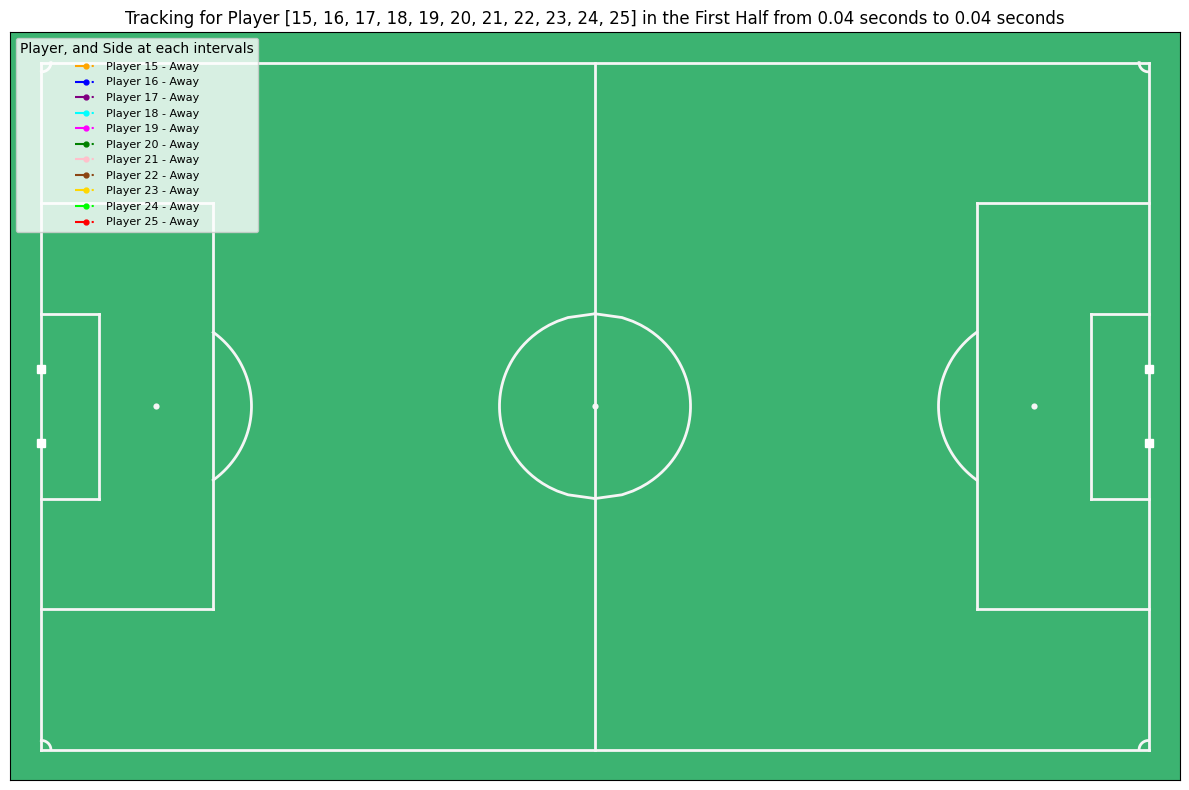

In [35]:
si_all = ["Away"] * 11
pl = list(range(15, 26))
game_2_pre.player_visualization(game_3_data.iloc[0:1], players=pl, sides=si_all, plot_ball=False)

In [36]:
game_3_data = game_2_pre._fill_missing_with_interpolation_and_fill(game_3_data)

In [37]:
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,-0.41787,-0.48086,-0.41215,-0.36689,-0.47050,-0.73219,-0.48864,-0.36357,0.50125,0.48725
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,-0.41719,-0.47864,-0.41132,-0.36169,-0.47040,-0.73204,-0.48834,-0.36362,0.50125,0.48725
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,-0.41697,-0.47824,-0.41131,-0.36072,-0.47075,-0.73229,-0.48814,-0.36372,0.50125,0.48725
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,-0.41685,-0.47815,-0.41117,-0.35930,-0.47118,-0.73266,-0.48793,-0.36278,0.50125,0.48725
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,-0.41669,-0.47749,-0.41120,-0.35910,-0.47163,-0.73287,-0.48784,-0.36240,0.50125,0.48725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,-0.58877,-0.56936,-0.50218,-0.65158,-0.46978,-0.62349,-0.80792,-0.27106,0.89207,0.50485
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,-0.58787,-0.56961,-0.50180,-0.65115,-0.46970,-0.62403,-0.80712,-0.27184,0.89207,0.50485
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,-0.58668,-0.57038,-0.50116,-0.65071,-0.46929,-0.62479,-0.80582,-0.27242,0.89207,0.50485
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,-0.58525,-0.57033,-0.50031,-0.65134,-0.46866,-0.62611,-0.80444,-0.27260,0.89207,0.50485


In [79]:
vel_acc_game_3_data = game_1_pre.vel_acc(game_3_data)
vel_acc_game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.058045,NaN,0.131646,NaN,0.004507,NaN,0.007603,NaN,0.0,NaN
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.011413,-1.165813,0.024251,-2.684858,0.010753,0.156149,0.005590,-0.050332,0.0,0.0
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.003750,-0.191568,0.035672,0.285521,0.014182,0.085724,0.024079,0.462228,0.0,0.0
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.016978,0.330698,0.005056,-0.765405,0.012415,-0.044179,0.009763,-0.357912,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.016508,0.052893,0.012260,0.120679,0.006828,0.061555,0.016900,-0.017704,0.0,0.0
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.023352,0.171109,0.014346,0.052149,0.013647,0.170477,0.027933,0.275813,0.0,0.0
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.035435,0.302072,0.019416,0.126758,0.021588,0.198528,0.035588,0.191374,0.0,0.0
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.035772,0.008426,0.026450,0.175848,0.036566,0.374435,0.034792,-0.019892,0.0,0.0


In [80]:
game_3_ply_tra = vel_acc_game_3_data.iloc[:, 2:]
game_3_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,0.62405,0.80669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,0.62371,0.80594,...,0.058045,NaN,0.131646,NaN,0.004507,NaN,0.007603,NaN,0.0,NaN
3,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,0.62354,0.80601,...,0.011413,-1.165813,0.024251,-2.684858,0.010753,0.156149,0.005590,-0.050332,0.0,0.0
4,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,0.62318,0.80604,...,0.003750,-0.191568,0.035672,0.285521,0.014182,0.085724,0.024079,0.462228,0.0,0.0
5,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,0.62286,0.80626,...,0.016978,0.330698,0.005056,-0.765405,0.012415,-0.044179,0.009763,-0.357912,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,0.50927,0.27457,...,0.016508,0.052893,0.012260,0.120679,0.006828,0.061555,0.016900,-0.017704,0.0,0.0
143758,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,0.50913,0.27654,...,0.023352,0.171109,0.014346,0.052149,0.013647,0.170477,0.027933,0.275813,0.0,0.0
143759,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,0.50876,0.27762,...,0.035435,0.302072,0.019416,0.126758,0.021588,0.198528,0.035588,0.191374,0.0,0.0
143760,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,0.50808,0.27935,...,0.035772,0.008426,0.026450,0.175848,0.036566,0.374435,0.034792,-0.019892,0.0,0.0


In [81]:
game_3_player_data = game_1_pre.get_frames(game_3_ply_tra, columns=game_3_ply_tra.columns[0:46:2]).round(4).fillna(0)
game_3_player_data

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_acceleration,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_acceleration,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_acceleration,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_acceleration,Ball-x,Ball-y,Ball_velocity,Ball_acceleration
1,0.8472,0.5286,0.0,0.0,0.6527,0.2479,0.0000,0.0000,0.6652,0.4656,...,0.0000,0.0000,-0.4886,-0.3636,0.0000,0.0000,0.5012,0.4872,0.0,0.0
2,0.8472,0.5286,0.0,0.0,0.6523,0.2451,0.0704,0.0000,0.6648,0.4655,...,0.0045,0.0000,-0.4883,-0.3636,0.0076,0.0000,0.5012,0.4872,0.0,0.0
3,0.8472,0.5286,0.0,0.0,0.6520,0.2439,0.0326,-0.9434,0.6647,0.4654,...,0.0108,0.1561,-0.4881,-0.3637,0.0056,-0.0503,0.5012,0.4872,0.0,0.0
4,0.8472,0.5286,0.0,0.0,0.6517,0.2429,0.0259,-0.1673,0.6646,0.4649,...,0.0142,0.0857,-0.4879,-0.3628,0.0241,0.4622,0.5012,0.4872,0.0,0.0
5,0.8472,0.5286,0.0,0.0,0.6514,0.2425,0.0112,-0.3693,0.6645,0.4647,...,0.0124,-0.0442,-0.4878,-0.3624,0.0098,-0.3579,0.5012,0.4872,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.1199,0.5178,0.0,0.0,0.4781,0.4541,0.0175,0.2063,0.4969,0.7731,...,0.0068,0.0616,-0.8079,-0.2711,0.0169,-0.0177,0.8921,0.5048,0.0,0.0
143758,0.1199,0.5178,0.0,0.0,0.4779,0.4552,0.0288,0.2816,0.4970,0.7743,...,0.0136,0.1705,-0.8071,-0.2718,0.0279,0.2758,0.8921,0.5048,0.0,0.0
143759,0.1199,0.5178,0.0,0.0,0.4774,0.4571,0.0482,0.4858,0.4969,0.7756,...,0.0216,0.1985,-0.8058,-0.2724,0.0356,0.1914,0.8921,0.5048,0.0,0.0
143760,0.1199,0.5178,0.0,0.0,0.4767,0.4595,0.0623,0.3524,0.4968,0.7764,...,0.0366,0.3744,-0.8044,-0.2726,0.0348,-0.0199,0.8921,0.5048,0.0,0.0


In [38]:
game_3_player_data = game_3_data.iloc[:, 2:]
game_3_player_data

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,0.62405,0.80669,...,-0.41787,-0.48086,-0.41215,-0.36689,-0.47050,-0.73219,-0.48864,-0.36357,0.50125,0.48725
2,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,0.62371,0.80594,...,-0.41719,-0.47864,-0.41132,-0.36169,-0.47040,-0.73204,-0.48834,-0.36362,0.50125,0.48725
3,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,0.62354,0.80601,...,-0.41697,-0.47824,-0.41131,-0.36072,-0.47075,-0.73229,-0.48814,-0.36372,0.50125,0.48725
4,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,0.62318,0.80604,...,-0.41685,-0.47815,-0.41117,-0.35930,-0.47118,-0.73266,-0.48793,-0.36278,0.50125,0.48725
5,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,0.62286,0.80626,...,-0.41669,-0.47749,-0.41120,-0.35910,-0.47163,-0.73287,-0.48784,-0.36240,0.50125,0.48725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,0.50927,0.27457,...,-0.58877,-0.56936,-0.50218,-0.65158,-0.46978,-0.62349,-0.80792,-0.27106,0.89207,0.50485
143758,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,0.50913,0.27654,...,-0.58787,-0.56961,-0.50180,-0.65115,-0.46970,-0.62403,-0.80712,-0.27184,0.89207,0.50485
143759,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,0.50876,0.27762,...,-0.58668,-0.57038,-0.50116,-0.65071,-0.46929,-0.62479,-0.80582,-0.27242,0.89207,0.50485
143760,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,0.50808,0.27935,...,-0.58525,-0.57033,-0.50031,-0.65134,-0.46866,-0.62611,-0.80444,-0.27260,0.89207,0.50485


In [39]:
with open("data/Sample_Game_3/Sample_Game_3_events.json", "r") as f:
    data = json.load(f)

In [40]:
type_ = np.array([])
start_frame = np.array([])
end_frame = np.array([])

for i in data["data"]:
    t = i["type"]["name"]
    sf = i["start"]["frame"]
    ef = i["end"]["frame"]

    if t != "CARRY":   
        type_ = np.append(type_, t)
        start_frame = np.append(start_frame, sf)
        end_frame = np.append(end_frame, ef)


game_3_event_data = pd.DataFrame({"Type": type_, "Start Frame": start_frame.astype(np.int64), "End Frame": end_frame.astype(np.int64)})

In [41]:
game_3_event_data = game_3_event_data[~(game_3_event_data["Type"] == "FAULT RECEIVED")]

game_3_event_data = game_3_event_data.replace("RECOVERY", "BALL LOST")

In [42]:
game_3_event_data

,Type,Start Frame,End Frame
0,SET PIECE,361,361
1,PASS,361,377
2,PASS,384,426
3,PASS,465,507
4,PASS,530,580
...,...,...,...
2220,PASS,143190,143265
2221,PASS,143265,143290
2222,PASS,143406,143469
2223,PASS,143469,143532


In [43]:
# game_3_event_data = fix_events(game_3_event_data)

In [44]:
start_frames = game_3_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = game_3_event_data["End Frame"].iloc[1:].to_numpy()
event_types = game_3_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = game_3_player_data.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(min(i, j), max(i, j) + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
game_3_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    game_3_event.loc[s:e, "Type"] = e_t

game_3_event = game_3_event.dropna()

In [45]:
# game_3_event = game_3_event[~(game_3_event["Type"] == "CARD")]
game_3_event#.drop()

,Type
361,PASS
362,PASS
363,PASS
364,PASS
365,PASS
...,...
143529,PASS
143530,PASS
143531,PASS
143532,PASS


In [46]:
valid_indices = game_3_event.index.intersection(game_3_player_data.index)
X_3 = game_3_player_data.loc[valid_indices]
y_3 = game_3_event.loc[valid_indices, "Type"]

In [47]:
X_3

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
361,0.84219,0.51681,0.63861,0.19465,0.73474,0.38597,0.71661,0.65952,0.55391,0.90220,...,-0.41560,-0.47430,-0.41384,-0.36745,-0.49025,-0.65068,-0.48714,-0.36308,0.50125,0.48725
362,0.84232,0.51649,0.63826,0.19424,0.73488,0.38666,0.71668,0.65969,0.55393,0.90261,...,-0.41584,-0.47443,-0.41406,-0.36780,-0.49038,-0.65010,-0.48732,-0.36310,0.50111,0.48724
363,0.84246,0.51620,0.63792,0.19398,0.73500,0.38738,0.71673,0.65993,0.55395,0.90302,...,-0.41610,-0.47458,-0.41430,-0.36810,-0.49055,-0.64946,-0.48753,-0.36305,0.50095,0.48723
364,0.84262,0.51583,0.63761,0.19364,0.73515,0.38793,0.71680,0.66012,0.55397,0.90340,...,-0.41636,-0.47458,-0.41454,-0.36831,-0.49077,-0.64890,-0.48778,-0.36303,0.50079,0.48721
365,0.84282,0.51546,0.63733,0.19331,0.73530,0.38849,0.71688,0.66031,0.55399,0.90378,...,-0.41665,-0.47469,-0.41481,-0.36846,-0.49101,-0.64828,-0.48807,-0.36314,0.50063,0.48720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143529,0.11993,0.51783,0.42811,0.48741,0.43863,0.79777,0.43239,0.63392,0.43707,0.32970,...,-0.63498,-0.60528,-0.53056,-0.77445,-0.41511,-0.60500,-0.75468,-0.20334,0.87713,0.53311
143530,0.11993,0.51783,0.42872,0.48704,0.43895,0.79718,0.43311,0.63370,0.43740,0.32903,...,-0.63547,-0.60520,-0.53076,-0.77417,-0.41543,-0.60508,-0.75576,-0.20261,0.87985,0.52767
143531,0.11993,0.51783,0.42932,0.48660,0.43928,0.79654,0.43382,0.63342,0.43772,0.32837,...,-0.63595,-0.60505,-0.53096,-0.77393,-0.41575,-0.60518,-0.75687,-0.20178,0.88258,0.52223
143532,0.11993,0.51783,0.42993,0.48618,0.43961,0.79595,0.43452,0.63314,0.43802,0.32764,...,-0.63642,-0.60491,-0.53114,-0.77364,-0.41607,-0.60521,-0.75800,-0.20099,0.88531,0.51679


In [91]:
# X_new = game_1_pre.expand_dataset(dataset=X_new, look_back=50)
# y_new = game_1_pre.expand_dataset(dataset=y_new, look_back=50)

In [92]:
warnings.filterwarnings("always")

In [93]:
def conf_matrix(y_train, y_train_pred, y_test, y_pred, labels, split, model_name=""):
    fig, ax = plt.subplots(figsize=(12, 10))
    
    cm_counts = confusion_matrix(y_test, y_pred, labels=labels)
    cm_normalized = confusion_matrix(y_test, y_pred, labels=labels, normalize="true")

    annot = []
    for i in range(len(cm_counts)):
        row_annot = []
        for j in range(len(cm_counts[i])):
            row_annot.append(f"{cm_counts[i, j]} | {cm_normalized[i, j]:.2f}")
        annot.append(row_annot)
    
    sns.heatmap(cm_normalized, 
                annot=annot,
                fmt="", 
                cmap="viridis", 
                xticklabels=labels, 
                yticklabels=labels,
                cbar_kws={"label": "Normalized Frequency"})

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"{model_name.title()} Confusion Matrix Split #{(split+1)}")
    plt.tight_layout()
    plt.show()
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Split #{(split+1)} {model_name} training accuracy: {train_accuracy * 100:0.2f}%")
    print(f"Split #{(split+1)} {model_name} testing accuracy: {test_accuracy * 100:0.2f}%\n")   

In [51]:
scaler = MinMaxScaler()
X_1_scaled = X_1.iloc[:, :].values#scaler.fit_transform(X_1)
X_2_scaled = X_2.iloc[:, :].values#scaler.transform(X_2)
X_3_scaled = X_3.iloc[:, :].values#scaler.transform(X_3)

In [52]:
label_encoder = LabelEncoder()
y_1_encoded = label_encoder.fit_transform(y_1)
y_2_encoded = label_encoder.transform(y_2)
y_3_encoded = label_encoder.transform(y_3)

In [53]:
print(np.unique(y_1_encoded, return_counts=True))
print(np.unique(y_2_encoded, return_counts=True))
print(np.unique(y_3_encoded, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6]), array([10006,  2871,     4,   132, 28247,    12,   619], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 7681,  2454,     6,   172, 32469,     9,   543], dtype=int64))
(array([0, 1, 2, 3, 4, 6]), array([11080,  2662,     1,   186, 43053,   403], dtype=int64))


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [55]:
nn_params = {
    "input_size": X_1.shape[1],
    "num_classes": np.unique(y_1).shape[0],
    "num_hidden_layers": 9,
    "dropout_rate": 0.2048869541357255,
    "hidden_size": 256,
}

learning_rate = 0.00044052948728804
batch_size = 256
num_epochs = 50

In [56]:
X_1_tensor = torch.FloatTensor(X_1_scaled)
y_1_tensor = torch.LongTensor(y_1_encoded)

X_2_tensor = torch.FloatTensor(X_2_scaled)
y_2_tensor = torch.LongTensor(y_2_encoded)

X_3_tensor = torch.FloatTensor(X_3_scaled)
y_3_tensor = torch.LongTensor(y_3_encoded)

X = torch.cat((X_1_tensor, X_2_tensor))
y = torch.cat((y_1_tensor, y_2_tensor))

assert X.shape[0] == y.shape[0]

d_1 = TensorDataset(X, y)
d_2 = TensorDataset(X_3_tensor, y_3_tensor)

train_loader = DataLoader(d_1, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(d_2, batch_size=batch_size, shuffle=True)

In [57]:
nn_model = get_model("nn", nn_params=nn_params).to(device)
nn_model

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=46, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2048869541357255, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2048869541357255, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2048869541357255, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2048869541357255, inplace=False)
    (16): Linear(in_features=256, out_features=256, bias=True)
    (

In [58]:
acc = train_model(nn_model, train_loader, validation_loader, num_epochs, "adam", nn.CrossEntropyLoss(), learning_rate, device)

Epoch 1/50: Train accuracy: 68.44% | Val accuracy: 72.68% | Train loss: 0.8589 | Val loss: 0.8050 | learning rate: 0.000441 | Precision: 65.52% | Recall: 72.68% | F1: 68.08%
Epoch 2/50: Train accuracy: 75.74% | Val accuracy: 72.29% | Train loss: 0.6040 | Val loss: 0.8511 | learning rate: 0.000441 | Precision: 65.35% | Recall: 72.29% | F1: 67.30%
Epoch 3/50: Train accuracy: 80.30% | Val accuracy: 71.71% | Train loss: 0.4952 | Val loss: 0.9601 | learning rate: 0.000441 | Precision: 64.90% | Recall: 71.71% | F1: 67.35%
Epoch 4/50: Train accuracy: 83.39% | Val accuracy: 73.47% | Train loss: 0.4247 | Val loss: 1.0596 | learning rate: 0.000441 | Precision: 65.75% | Recall: 73.47% | F1: 67.35%
Epoch 5/50: Train accuracy: 85.57% | Val accuracy: 73.52% | Train loss: 0.3733 | Val loss: 1.0839 | learning rate: 0.000441 | Precision: 65.82% | Recall: 73.52% | F1: 67.25%
Epoch 6/50: Train accuracy: 87.19% | Val accuracy: 72.89% | Train loss: 0.3345 | Val loss: 1.0887 | learning rate: 0.000441 | Prec

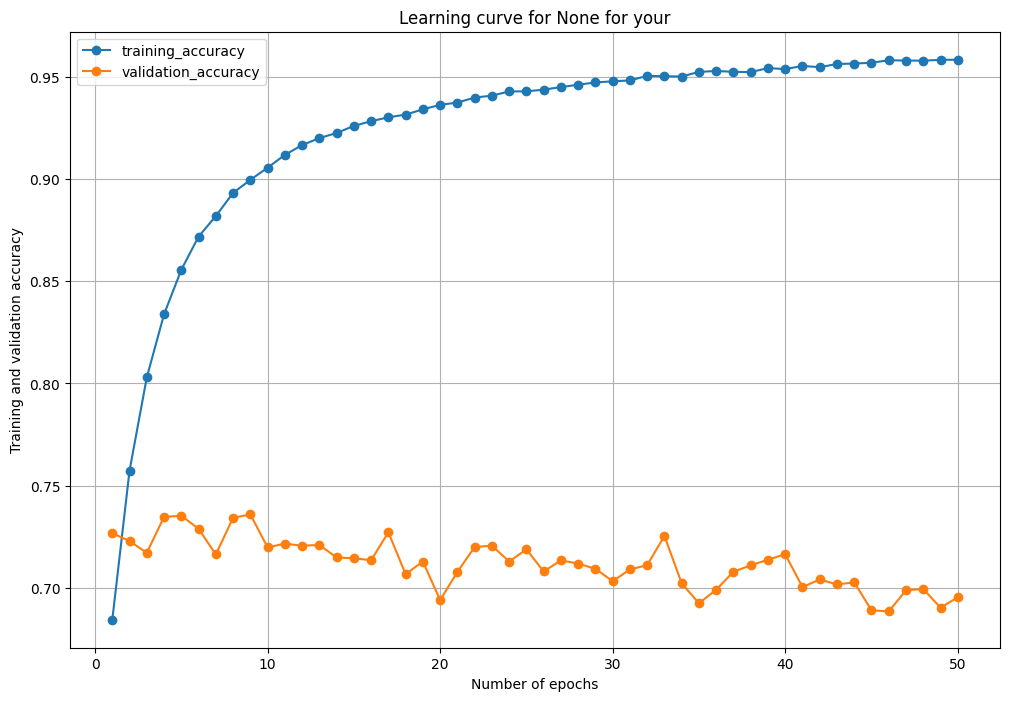

In [61]:
plot_accuracy(acc, title="None for your")

In [143]:
X_1_tensor = torch.FloatTensor(X_1_scaled)
y_1_tensor = torch.LongTensor(y_1_encoded)

X_2_tensor = torch.FloatTensor(X_2_scaled)
y_2_tensor = torch.LongTensor(y_2_encoded)

X_3_tensor = torch.FloatTensor(X_3_scaled)
y_3_tensor = torch.LongTensor(y_3_encoded)

X = torch.cat((X_1_tensor, X_2_tensor))
y = torch.cat((y_1_tensor, y_2_tensor))

assert X.shape[0] == y.shape[0]

d_1 = TensorDataset(X, y)
d_2 = TensorDataset(X_3_tensor, y_3_tensor)

In [144]:
def objective(trial):
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    num_epochs = 150 
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256, 512])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
    if optimizer_name == "sgd":
        learning_rate = trial.suggest_float('learning_rate', 1e-2, 1, log=True)
    else:
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 3, 15)

    # Update your model's parameters using the trial's suggestions
    nn_params = {
        "input_size": X_1.shape[1],
        "num_classes": np.unique(y_2).shape[0],
        "num_hidden_layers": num_hidden_layers,
        "dropout_rate": dropout_rate,
        "hidden_size": hidden_size,
    }

    # Recreate the model with the current hyperparameters
    nn_model = get_model("nn", nn_params=nn_params).to(device)

    train_loader = DataLoader(d_1, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(d_2, batch_size=batch_size, shuffle=True)

    # Train the model and get the accuracy (or any other metric)
    acc = train_model(nn_model, train_loader, validation_loader, num_epochs, 
                      optimizer_name=optimizer_name, 
                      criterion=nn.CrossEntropyLoss(), 
                      learning_rate=learning_rate, 
                      device=device, verbose=False)
    
    # Return accuracy as the objective metric (Optuna will try to maximize it)
    # print(np.mean(acc["validation_accuracy"][-20:]))
    return np.mean([np.mean(acc["training_accuracy"][-20:]), np.mean(acc["validation_accuracy"][-20:])])

# Create an Optuna study to optimize the objective
study = optuna.create_study(direction='maximize')  # direction='maximize' because we're optimizing accuracy
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print(f"Best trial: {study.best_trial.params}")
print(f"Best accuracy: {study.best_value}")

[I 2025-02-03 00:33:19,212] A new study created in memory with name: no-name-de354e23-6f18-48f5-946e-50f9507543f3
[I 2025-02-03 00:37:48,059] Trial 0 finished with value: 0.8200015697087288 and parameters: {'batch_size': 256, 'dropout_rate': 0.44459648606314117, 'hidden_size': 128, 'optimizer': 'adam', 'learning_rate': 0.003704343022385407, 'num_hidden_layers': 4}. Best is trial 0 with value: 0.8200015697087288.
[I 2025-02-03 00:46:55,824] Trial 1 finished with value: 0.8438288075890323 and parameters: {'batch_size': 128, 'dropout_rate': 0.3877485815195368, 'hidden_size': 512, 'optimizer': 'adam', 'learning_rate': 0.029747503343486446, 'num_hidden_layers': 9}. Best is trial 1 with value: 0.8438288075890323.
[I 2025-02-03 00:50:31,182] Trial 2 finished with value: 0.855579503619327 and parameters: {'batch_size': 512, 'dropout_rate': 0.4857252453095354, 'hidden_size': 512, 'optimizer': 'adam', 'learning_rate': 0.005402141023158405, 'num_hidden_layers': 8}. Best is trial 2 with value: 0.8

Best trial: {'batch_size': 256, 'dropout_rate': 0.42619325517170303, 'hidden_size': 512, 'optimizer': 'adam', 'learning_rate': 0.0005558424109878678, 'num_hidden_layers': 11}
Best accuracy: 0.8621322464588135


In [ ]:
42, 15,13

In [60]:
def plot_accuracy(history, title=""):
    fig, ax = plt.subplots(figsize=(12, 8))

    for metric, results in history.items():
        ax.plot(list(range(1, num_epochs + 1)), results, marker="o", label=metric)
    # ax.plot(list(range(1, num_epochs + 1)), accuracy["testing_accuracy"], marker="o", label="Testing Accuracy")

    ax.set_xlabel("Number of epochs")
    ax.set_ylabel("Training and validation accuracy")
    ax.set_title(f"Learning curve for {title}")
    
    ax.grid(True)
    ax.legend()
    
    plt.show()

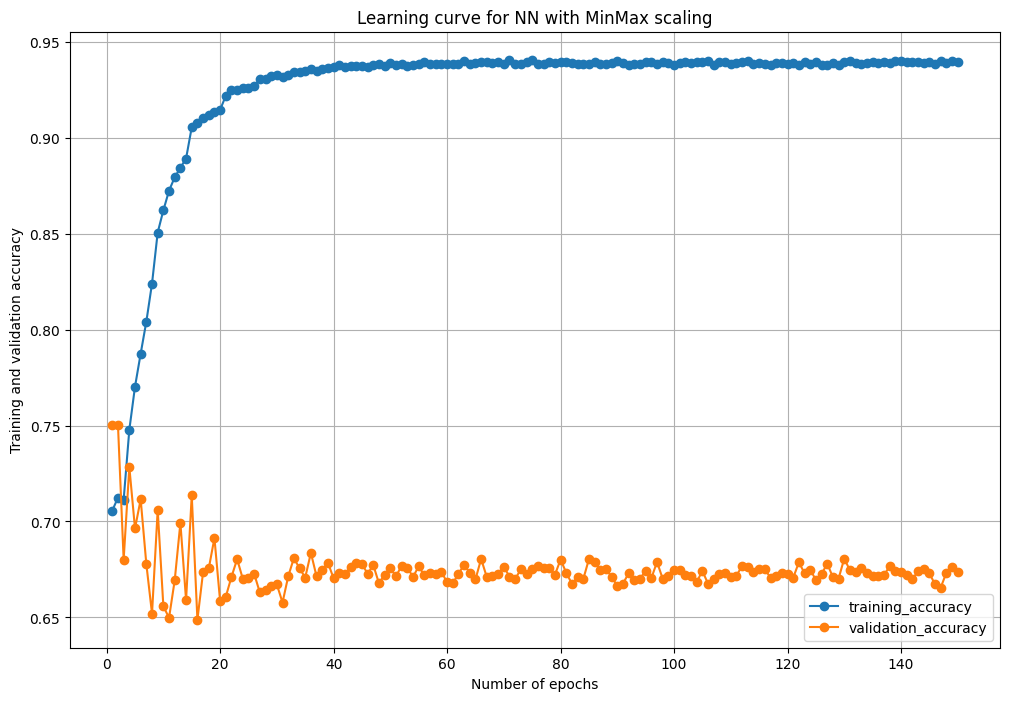

In [146]:
plot_accuracy(acc, title="NN with MinMax scaling")

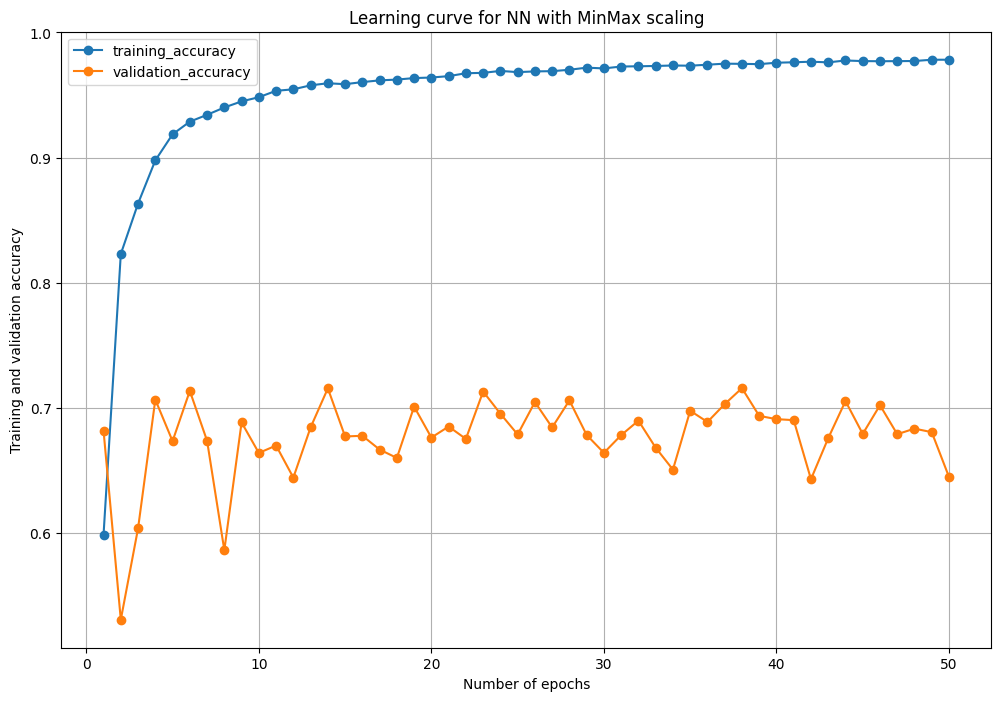

In [63]:
plot_accuracy(acc, title="NN with MinMax scaling")

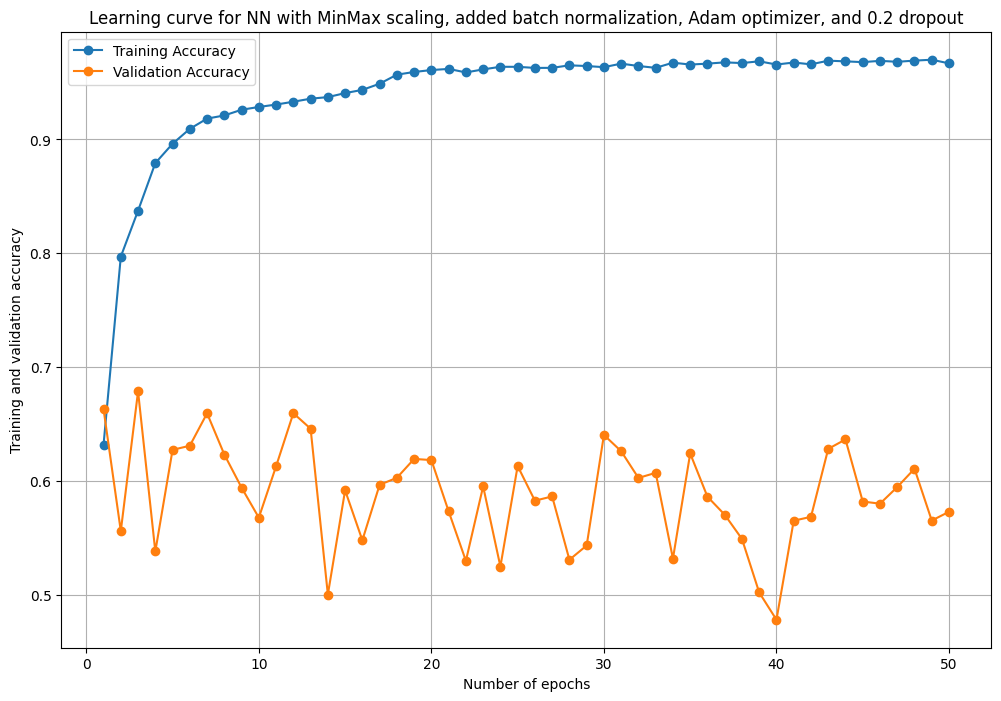

In [69]:
plot_accuracy(accu, title="NN with MinMax scaling, added batch normalization, Adam optimizer, and 0.2 dropout")

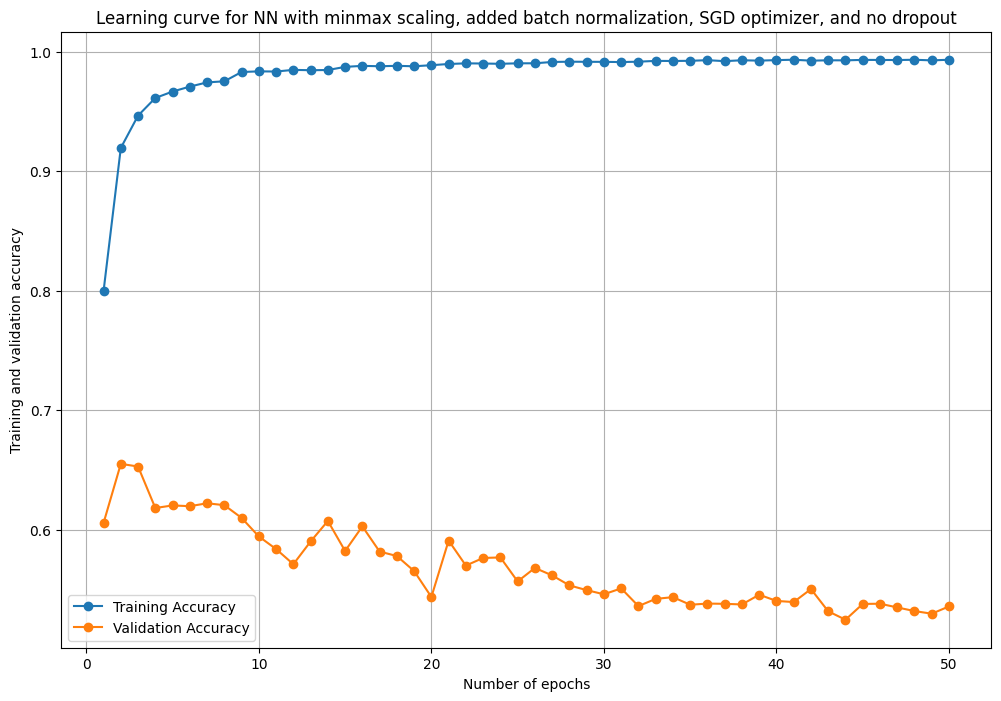

In [54]:
plot_accuracy(accuracy, title="NN with minmax scaling, added batch normalization, SGD optimizer, and no dropout")

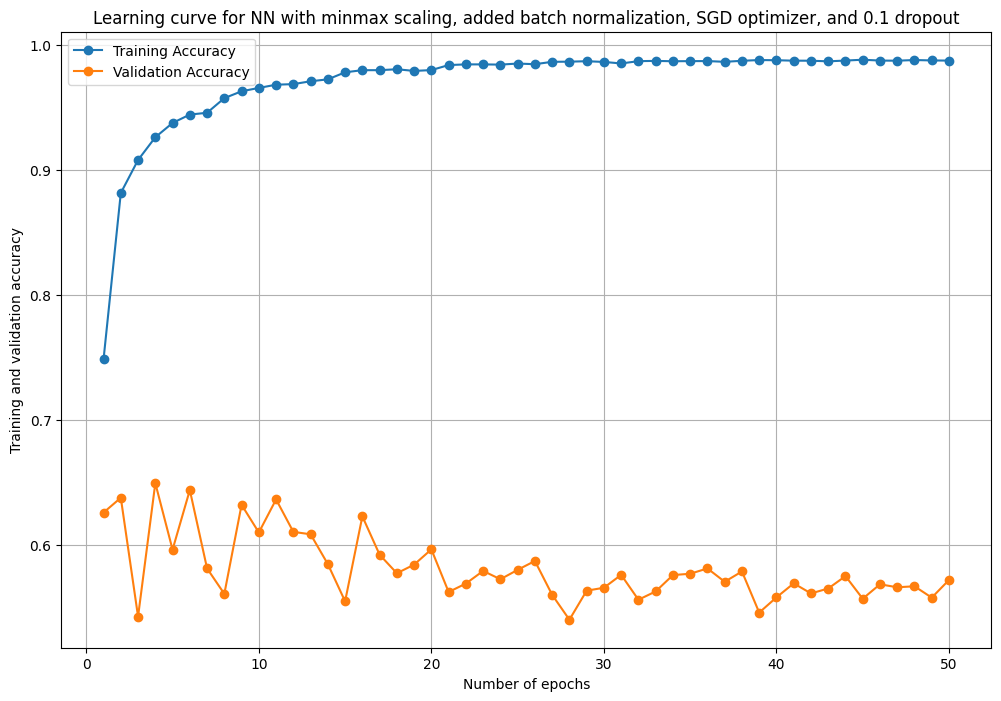

In [43]:
plot_accuracy(accu, title="NN with minmax scaling, added batch normalization, SGD optimizer, and 0.1 dropout")

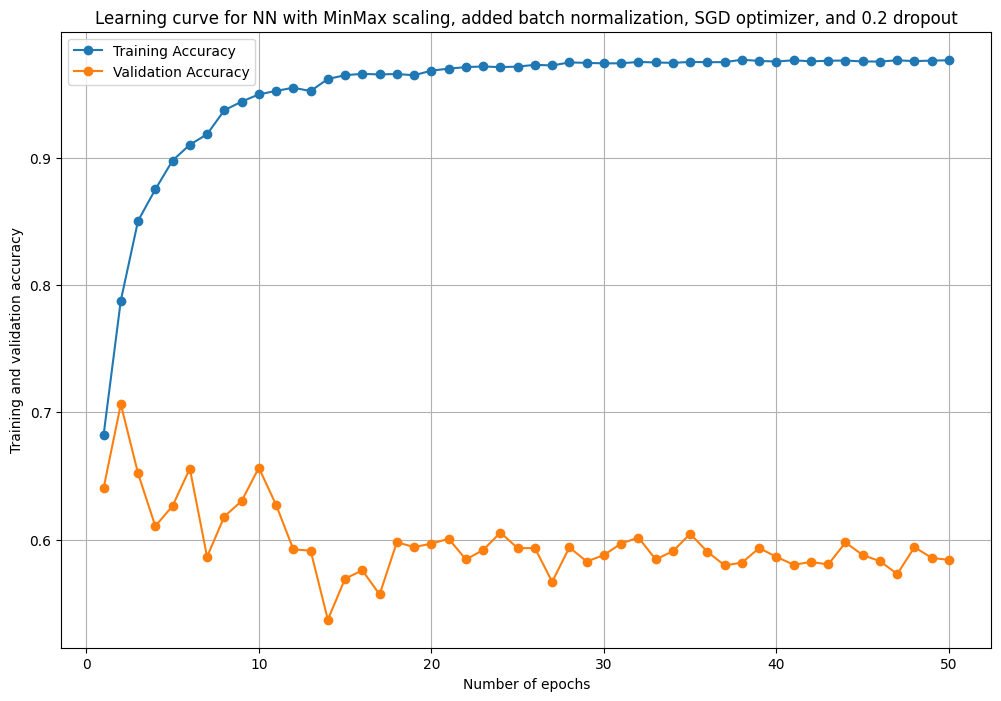

In [62]:
plot_accuracy(accu, title="NN with MinMax scaling, added batch normalization, SGD optimizer, and 0.2 dropout")